In [29]:
import scipy.io as sio
data = sio.loadmat('URpickNplace.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Feb 26 20:08:47 2015',
 '__version__': '1.0',
 '__globals__': [],
 'urPicknPlace': array([[ 0.0202, -1.5547, -0.0255, ...,  0.4891, -1.8791, -0.1669],
        [ 0.0202, -1.5547, -0.0255, ...,  0.4333, -1.7954, -0.1669],
        [ 0.0202, -1.5547, -0.0255, ...,  0.3775, -1.8512, -0.0279],
        ...,
        [ 0.0202, -1.5547, -0.0255, ...,  0.3217, -1.907 , -0.1948],
        [ 0.0202, -1.5547, -0.0255, ...,  0.21  , -1.907 , -0.1948],
        [ 0.0202, -1.5547, -0.0255, ...,  0.2658, -1.8512, -0.1948]]),
 'urPicknPlaceHyper': array([[-3.05840e+00, -2.33240e+00, -1.47950e+00, ...,  1.19303e+01,
         -3.11790e+00, -4.72900e-01],
        [-1.00000e-04, -1.57080e+00,  0.00000e+00, ...,  2.70710e+00,
          2.62200e+00,  2.75380e+00],
        [ 2.02000e-02, -1.55470e+00, -2.55000e-02, ...,  4.61200e-01,
         -1.85120e+00, -2.22600e-01],
        ...,
        [-2.55260e+00, -1.89180e+00, -3.60300e-01, ..., -9

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

input_data = data['urPicknPlace']
output_data = data['urPicknPlaceHyper']

# Convert the data to PyTorch tensors
X = torch.tensor(input_data, dtype=torch.float32)
Y = torch.tensor(output_data, dtype=torch.float32)
# Normalize the input data
X_mean = X.mean(dim=0)
X_std = X.std(dim=0)
X = (X - X_mean) / X_std
# Check the shapes of the tensors
print("Input tensor shape:", X.shape)
print("Output tensor shape:", Y.shape)

Input tensor shape: torch.Size([12349, 24])
Output tensor shape: torch.Size([2000, 24])


In [46]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Shuffle the data indices for X
indices_X = torch.randperm(X.shape[0])

# Select a subset of X that matches the size of Y
X_subset = X[indices_X[:Y.shape[0]]]

# Shuffle the data indices for Y
indices_Y = torch.randperm(Y.shape[0])

# Split the data for X and Y
train_size = int(0.6 * Y.shape[0])
val_size = int(0.2 * Y.shape[0])
test_size = Y.shape[0] - train_size - val_size

X_train = X_subset[indices_Y[:train_size]]
X_val = X_subset[indices_Y[train_size: train_size + val_size]]
X_test = X_subset[indices_Y[train_size + val_size:]]

Y_train = Y[indices_Y[:train_size]]
Y_val = Y[indices_Y[train_size: train_size + val_size]]
Y_test = Y[indices_Y[train_size + val_size:]]

# Print the shapes of the datasets to verify
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([1200, 24])
X_val shape: torch.Size([400, 24])
X_test shape: torch.Size([400, 24])
Y_train shape: torch.Size([1200, 24])
Y_val shape: torch.Size([400, 24])
Y_test shape: torch.Size([400, 24])


In [47]:
# Define your data augmentation transformations
def random_horizontal_flip(tensor, p=0.5):
    if torch.rand(1) < p:
        return torch.flip(tensor, dims=[-1])
    return tensor

# Create data loaders with data augmentation for the training set
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = AugmentedDataset(X_train, Y_train, transform=random_horizontal_flip)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create a validation data loader without data augmentation
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [48]:
import torch.nn as nn

class DeterministicModel(nn.Module):
    def __init__(self, input_dim, output_dim,dropout_prob=0.7):
        super(DeterministicModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(16,16)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(16, output_dim)
        self.dropout3 = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

Training with batch size: 64
Epoch 0/100, Train Loss: 45.2935, Val Loss: 36.7105
Epoch 1/100, Train Loss: 45.3108, Val Loss: 36.5931
Epoch 2/100, Train Loss: 45.2973, Val Loss: 36.4638
Epoch 3/100, Train Loss: 44.9935, Val Loss: 36.3388
Epoch 4/100, Train Loss: 44.8692, Val Loss: 36.1744
Epoch 5/100, Train Loss: 44.8785, Val Loss: 35.9990
Epoch 6/100, Train Loss: 44.5429, Val Loss: 35.7683
Epoch 7/100, Train Loss: 44.5290, Val Loss: 35.5149
Epoch 8/100, Train Loss: 44.2538, Val Loss: 35.1789
Epoch 9/100, Train Loss: 44.2713, Val Loss: 34.8729
Epoch 10/100, Train Loss: 44.0188, Val Loss: 34.6246
Epoch 11/100, Train Loss: 43.4196, Val Loss: 34.2677
Epoch 12/100, Train Loss: 43.2447, Val Loss: 33.9715
Epoch 13/100, Train Loss: 43.2605, Val Loss: 33.7214
Epoch 14/100, Train Loss: 43.2162, Val Loss: 33.5959
Epoch 15/100, Train Loss: 43.0978, Val Loss: 33.4474
Epoch 16/100, Train Loss: 42.9055, Val Loss: 33.2936
Epoch 17/100, Train Loss: 42.9007, Val Loss: 33.1293
Epoch 18/100, Train Loss: 4

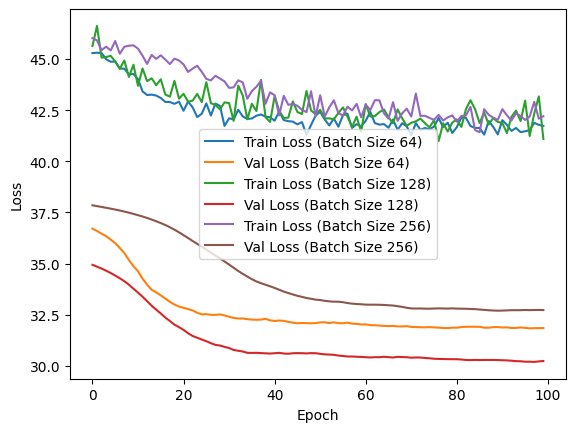

In [50]:
# Training loop with different batch sizes
batch_sizes = [64,128,256]
num_epochs = 100

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    
    # Create data loaders for the current batch size
    train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create the model and optimizer
    input_dim = X_train.shape[1]
    output_dim = Y_train.shape[1]
    deterministic_model = DeterministicModel(input_dim, output_dim)
    optimizer = optim.Adam(deterministic_model.parameters(), lr=0.001,weight_decay=0.01)
    criterion = nn.MSELoss()

    # Training loop for the current batch size
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        deterministic_model.train()
        total_train_loss = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = deterministic_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        deterministic_model.eval()
        with torch.no_grad():
            total_val_loss = 0

            for inputs, targets in val_loader:
                val_outputs = deterministic_model(inputs)
                val_loss = criterion(val_outputs, targets)
                total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plot the losses for the current batch size
    plt.plot(train_losses, label=f"Train Loss (Batch Size {batch_size})")
    plt.plot(val_losses, label=f"Val Loss (Batch Size {batch_size})")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [35]:
# Define the Gaussian model
class GaussianModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GaussianModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.mean_layer = nn.Linear(64, output_dim)
        self.log_var_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        return mean, log_var


In [36]:
# Create the Gaussian model
input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]
gaussian_model = GaussianModel(input_dim, output_dim)

# Define loss function
def gaussian_nll_loss(y_true, mean, log_var):
    var = torch.exp(log_var)
    nll_loss = 0.5 * torch.mean(torch.log(var) + ((y_true - mean)**2) / var + torch.log(2 * torch.tensor(np.pi)))
    return nll_loss

# Define optimizer
optimizer = optim.Adam(gaussian_model.parameters(), lr=0.001)

In [37]:
# Training loop
num_epochs = 50
batch_size = 16

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Shuffle the data indices
    indices = torch.randperm(len(X_train))
    X_shuffled = X_train[indices]
    Y_shuffled = Y_train[indices]

    total_loss = 0

    for i in range(0, len(X_train), batch_size):
        # Get the batch
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]

        # Forward pass
        mean, log_var = gaussian_model(X_batch)

        # Calculate loss
        loss = gaussian_nll_loss(Y_batch, mean, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = total_loss / (len(X_train) // batch_size)
    train_losses.append(avg_loss)

    # Validation
    with torch.no_grad():
        val_mean, val_log_var = gaussian_model(X_val)
        val_loss = gaussian_nll_loss(Y_val, val_mean, val_log_var).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 0/50, Train Loss: 11.2525, Val Loss: 2.7031
Epoch 1/50, Train Loss: 3.1231, Val Loss: 1.9537
Epoch 2/50, Train Loss: 1.8539, Val Loss: 1.6772
Epoch 3/50, Train Loss: 1.6295, Val Loss: 1.5683
Epoch 4/50, Train Loss: 1.5617, Val Loss: 1.5348
Epoch 5/50, Train Loss: 1.5252, Val Loss: 1.5070
Epoch 6/50, Train Loss: 1.5011, Val Loss: 1.4824
Epoch 7/50, Train Loss: 1.4755, Val Loss: 1.4604
Epoch 8/50, Train Loss: 1.4848, Val Loss: 1.4958
Epoch 9/50, Train Loss: 1.4662, Val Loss: 1.4460
Epoch 10/50, Train Loss: 1.4425, Val Loss: 1.4425
Epoch 11/50, Train Loss: 1.4203, Val Loss: 1.4253
Epoch 12/50, Train Loss: 1.4104, Val Loss: 1.4170
Epoch 13/50, Train Loss: 1.4092, Val Loss: 1.4117
Epoch 14/50, Train Loss: 1.4034, Val Loss: 1.4116
Epoch 15/50, Train Loss: 1.3914, Val Loss: 1.4025
Epoch 16/50, Train Loss: 1.3807, Val Loss: 1.3997
Epoch 17/50, Train Loss: 1.3747, Val Loss: 1.3941
Epoch 18/50, Train Loss: 1.3703, Val Loss: 1.3942
Epoch 19/50, Train Loss: 1.3658, Val Loss: 1.3918
Epoch 20/

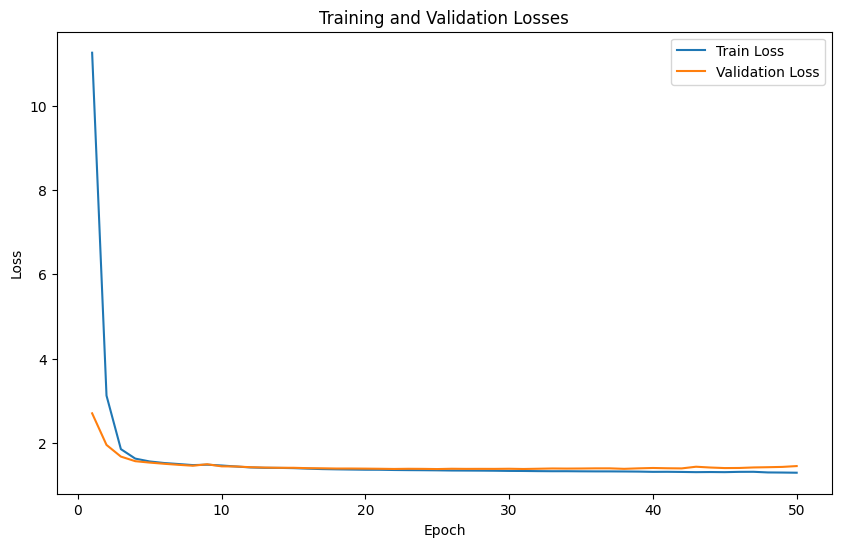

In [38]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [39]:
import scipy.stats as stats

def evaluate_deterministic_model(model, train_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            all_predictions.extend(outputs.numpy())
            all_targets.extend(targets.numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Calculate the mean squared error (MSE)
    mse = ((all_predictions - all_targets) ** 2).mean()

    # Calculate the p-value using the t-test
    _, p_value = stats.ttest_rel(all_predictions, all_targets)

    # Convert the p-value array to a scalar value (e.g., by taking the mean)
    p_value_scalar = np.mean(p_value)

    return mse, p_value_scalar

# Evaluate the deterministic model on the validation set
deterministic_mse, deterministic_p_value = evaluate_deterministic_model(deterministic_model, val_loader)

print("Deterministic Model:")
print(f"Mean Squared Error (MSE): {deterministic_mse:.4f}")
print(f"P-value: {deterministic_p_value:.4f}")

Deterministic Model:
Mean Squared Error (MSE): 33.5595
P-value: 0.2569


In [40]:
import torch
from scipy import stats

def evaluate_gaussian_model(model, train_loader):
    model.eval()
    predicted_means = []
    predicted_stds = []
    ground_truth = []

    with torch.no_grad():
        for inputs, targets in train_loader:
            mean, log_var = model(inputs)
            std = torch.exp(0.5 * log_var)  # Convert log_var to std
            predicted_means.append(mean)
            predicted_stds.append(std)
            ground_truth.append(targets)

    predicted_means = torch.cat(predicted_means, dim=0)
    predicted_stds = torch.cat(predicted_stds, dim=0)
    ground_truth = torch.cat(ground_truth, dim=0)

    # Add a small epsilon to predicted_stds to avoid division by zero
    epsilon = 1e-8
    predicted_stds = torch.clamp(predicted_stds, min=epsilon)

    # Calculate the p-values for each predicted sample
    p_values = stats.norm.cdf(ground_truth.cpu().numpy(), loc=predicted_means.cpu().numpy(), scale=predicted_stds.cpu().numpy())

    # Calculate the mean p-value across all samples and dimensions
    mean_p_value = torch.mean(torch.tensor(p_values))

    return mean_p_value

# Evaluate the Gaussian model on the validation set
mean_p_value = evaluate_gaussian_model(gaussian_model, val_loader)
print(f"Mean P-Value: {mean_p_value.item()}")

Mean P-Value: 0.511398443814593
